### Contexte et setup (imports, reproductibilité)

In [34]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

notebook_dir = Path.cwd()
project_root = notebook_dir.parent
out_dir = project_root / "data"
dim_dir = out_dir / "dim"
fact_dir = out_dir / "fact"

for d in [out_dir, dim_dir, fact_dir]:
    d.mkdir(parents=True, exist_ok=True)


### Génération RAW : clients et produits

In [35]:
countries = ["FR", "DE", "ES", "IT", "UK", "US"]
raw_customers = pd.DataFrame({
    "customer_id": range(1, 121),
    "name": [f"Cust {i}" for i in range(1, 121)],
    "email": [f"user{i}@example.com" for i in range(1, 121)],
    "country": rng.choice(countries, 120)
})

categories = ["Electronics", "Home", "Sports", "Toys"]
raw_products = pd.DataFrame({
    "product_id": range(1, 61),
    "product_name": [f"Item {i}" for i in range(1, 61)],
    "category": rng.choice(categories, 60),
    "brand": rng.choice(["Acme", "Globex", "Umbrella", "Initech", "Soylent"], 60),
    "unit_price": np.round(rng.uniform(10, 300, 60), 2)
})
raw_products["unit_cost"] = np.round(raw_products["unit_price"] * rng.uniform(0.6, 0.8, 60), 2)

### Génération RAW : lignes de commande (order lines)

In [36]:
start, end = datetime(2025, 1, 1), datetime(2025, 9, 30)
N = 2500

raw_orders = pd.DataFrame({
    "order_id": 10000 + rng.integers(0, 10000, N),
    "order_line_id": range(1, N + 1),
    "order_ts": [start + timedelta(days=int(rng.integers(0, (end - start).days + 1))) for _ in range(N)],
    "customer_id": rng.integers(1, 121, N),
    "product_id": rng.integers(1, 61, N),
    "quantity": rng.integers(1, 6, N)
})


In [37]:
raw_dir = out_dir / "raw"
raw_dir.mkdir(parents=True, exist_ok=True)

raw_customers_path = raw_dir / "raw_customers.csv"
raw_products_path = raw_dir / "raw_products.csv"
raw_orders_path = raw_dir / "raw_orders.csv"

In [38]:
raw_customers.to_csv(raw_customers_path, index=False)
raw_products.to_csv(raw_products_path, index=False)
raw_orders.to_csv(raw_orders_path, index=False)

print(" RAW Données enregistrées avec succès：")
for path in [raw_customers_path, raw_products_path, raw_orders_path]:
    if path.exists():
        print(f"{path.name} Enregistré avec succès, emplacement：{path.resolve()}")
    else:
        print(f"{path.name} Enregistré avec succès")

 RAW Données enregistrées avec succès：
raw_customers.csv Enregistré avec succès, emplacement：C:\Users\24160\Desktop\TP\data\raw\raw_customers.csv
raw_products.csv Enregistré avec succès, emplacement：C:\Users\24160\Desktop\TP\data\raw\raw_products.csv
raw_orders.csv Enregistré avec succès, emplacement：C:\Users\24160\Desktop\TP\data\raw\raw_orders.csv


### Staging : nettoyage et standardisation

In [39]:
stg_customers = raw_customers.assign(
    email = raw_customers["email"].str.strip().str.lower(),
    country = raw_customers["country"].str.upper()
)

stg_products = raw_products.assign(
    category = raw_products["category"].str.title(),
    brand = raw_products["brand"].str.title()
)

stg_orders = raw_orders.assign(
    order_ts = pd.to_datetime(raw_orders["order_ts"])
)

### Dimensions : dim_date, dim_product, dim_customer

In [40]:
dim_date = (
    pd.DataFrame({"date": pd.to_datetime(stg_orders["order_ts"].unique())})
    .sort_values("date")
    .reset_index(drop=True)
)

dim_date["date_sk"] = range(1, len(dim_date) + 1)

dim_date = dim_date.assign(
    day     = dim_date["date"].dt.day,
    month   = dim_date["date"].dt.month,
    quarter = dim_date["date"].dt.quarter,
    year    = dim_date["date"].dt.year,
    week    = dim_date["date"].dt.isocalendar().week
)

print("Dimension dim_date construite avec succès.")
print(f"Nombre de dates uniques : {len(dim_date)}")
print("Aperçu de la table :")
display(dim_date.head()) 

print("\nStructure:")
print(dim_date.dtypes)


Dimension dim_date construite avec succès.
Nombre de dates uniques : 273
Aperçu de la table :


,date,date_sk,day,month,quarter,year,week
0,2025-01-01,1,1,1,1,2025,1
1,2025-01-02,2,2,1,1,2025,1
2,2025-01-03,3,3,1,1,2025,1
3,2025-01-04,4,4,1,1,2025,1
4,2025-01-05,5,5,1,1,2025,1



Structure:
date       datetime64[ns]
date_sk             int64
day                 int32
month               int32
quarter             int32
year                int32
week               UInt32
dtype: object


In [41]:
dim_product = stg_products.drop_duplicates("product_id").reset_index(drop=True)
dim_product["product_sk"] = range(1, len(dim_product) + 1)

dim_customer = stg_customers.drop_duplicates("customer_id").reset_index(drop=True)
dim_customer["customer_sk"] = range(1, len(dim_customer) + 1)

print("Dimensions dim_product et dim_customer construites avec succès.\n")

print(f"Nombre de produits : {len(dim_product)}")
display(dim_product.head())

print(f"\nNombre de clients : {len(dim_customer)}")
display(dim_customer.head())

print("\nStructures:")
print("dim_product:")
print(dim_product.dtypes)
print("\ndim_customer:")
print(dim_customer.dtypes)


Dimensions dim_product et dim_customer construites avec succès.

Nombre de produits : 60


,product_id,product_name,category,brand,unit_price,unit_cost,product_sk
0,1,Item 1,Home,Soylent,179.39,139.59,1
1,2,Item 2,Sports,Acme,198.46,154.54,2
2,3,Item 3,Sports,Umbrella,34.49,24.27,3
3,4,Item 4,Home,Initech,130.58,86.60,4
4,5,Item 5,Toys,Umbrella,22.07,16.65,5



Nombre de clients : 120


,customer_id,name,email,country,customer_sk
0,1,Cust 1,user1@example.com,FR,1
1,2,Cust 2,user2@example.com,UK,2
2,3,Cust 3,user3@example.com,IT,3
3,4,Cust 4,user4@example.com,ES,4
4,5,Cust 5,user5@example.com,ES,5



Structures:
dim_product:
product_id        int64
product_name     object
category         object
brand            object
unit_price      float64
unit_cost       float64
product_sk        int64
dtype: object

dim_customer:
customer_id     int64
name           object
email          object
country        object
customer_sk     int64
dtype: object


### Table de faits : fact_sales (quantité, montant, coût, marge)

In [42]:
fact = (
    stg_orders
    .merge(dim_customer[["customer_id", "customer_sk"]], on="customer_id")
    .merge(dim_product[["product_id", "product_sk", "unit_price", "unit_cost"]], on="product_id")
    .merge(dim_date[["date", "date_sk"]], left_on="order_ts", right_on="date")
)

fact["amount"] = fact["quantity"] * fact["unit_price"]
fact["cost"] = fact["quantity"] * fact["unit_cost"]
fact["margin"] = fact["amount"] - fact["cost"]

fact_sales = fact[[
    "order_id", "order_line_id", "date_sk", "product_sk", "customer_sk",
    "quantity", "unit_price", "amount", "cost", "margin"
]].sort_values(["order_id", "order_line_id"])

print("Table de faits fact_sales construite avec succès.")
print(f"Nombre de lignes : {len(fact_sales)}")
display(fact_sales.head())

print("\nStructure:")
print(fact_sales.dtypes)


Table de faits fact_sales construite avec succès.
Nombre de lignes : 2500


,order_id,order_line_id,date_sk,product_sk,customer_sk,quantity,unit_price,amount,cost,margin
1835,10005,1836,82,8,51,1,51.91,51.91,32.13,19.78
1961,10010,1962,122,38,77,3,201.23,603.69,377.16,226.53
1007,10012,1008,20,7,36,5,105.66,528.30,356.45,171.85
1778,10012,1779,124,54,18,1,281.45,281.45,202.42,79.03
928,10015,929,54,20,64,4,33.99,135.96,90.00,45.96



Structure:
order_id           int64
order_line_id      int64
date_sk            int64
product_sk         int64
customer_sk        int64
quantity           int64
unit_price       float64
amount           float64
cost             float64
margin           float64
dtype: object


In [43]:
dim_dir = out_dir / "dim"
dim_dir.mkdir(parents=True, exist_ok=True)

dim_date_path = dim_dir / "dim_date.csv"
dim_product_path = dim_dir / "dim_product.csv"
dim_customer_path = dim_dir / "dim_customer.csv"

dim_date.to_csv(dim_date_path, index=False)
dim_product[[
    "product_sk", "product_id", "product_name", "category", "brand",
    "unit_price", "unit_cost"
]].to_csv(dim_product_path, index=False)
dim_customer[[
    "customer_sk", "customer_id", "name", "email", "country"
]].to_csv(dim_customer_path, index=False)

fact_path = out_dir / "fact_sales.csv"
fact_sales.to_csv(fact_path, index=False)

print("Fichiers sauvegardés avec succès :")
for path in [dim_date_path, dim_product_path, dim_customer_path, fact_path]:
    status = "OK" if path.exists() else "ERREUR"
    print(f"{status} - {path.resolve()}")


Fichiers sauvegardés avec succès :
OK - C:\Users\24160\Desktop\TP\data\dim\dim_date.csv
OK - C:\Users\24160\Desktop\TP\data\dim\dim_product.csv
OK - C:\Users\24160\Desktop\TP\data\dim\dim_customer.csv
OK - C:\Users\24160\Desktop\TP\data\fact_sales.csv


### Agrégations : ventes mensuelles, top 10 produits

In [44]:
sales_by_month = (
    fact_sales
    .merge(dim_date[["date_sk", "month", "year"]], on="date_sk")
    .groupby(["year", "month"], as_index=False)["amount"]
    .sum()
    .sort_values(["year", "month"])
)

top_products = (
    fact_sales
    .merge(dim_product[["product_sk", "product_name"]], on="product_sk")
    .groupby(["product_sk", "product_name"], as_index=False)["amount"]
    .sum()
    .sort_values("amount", ascending=False)
    .head(10)
)


In [45]:
print("Ventes mensuelles :")
print(sales_by_month.head())

print("\nStructure :")
print(sales_by_month.dtypes)


print("\nTop 10 produits par chiffre d'affaires :")
print(top_products.head())

print("\nStructure :")
print(top_products.dtypes)


Ventes mensuelles :
   year  month     amount
0  2025      1  124990.29
1  2025      2  101977.92
2  2025      3  126423.63
3  2025      4  131557.13
4  2025      5  130404.35

Structure :
year        int32
month       int32
amount    float64
dtype: object

Top 10 produits par chiffre d'affaires :
    product_sk product_name    amount
30          31      Item 31  42185.78
16          17      Item 17  39453.26
53          54      Item 54  37151.40
39          40      Item 40  35635.23
58          59      Item 59  35453.88

Structure :
product_sk        int64
product_name     object
amount          float64
dtype: object


### Graphique : chiffre d’affaires mensuel (matplotlib)

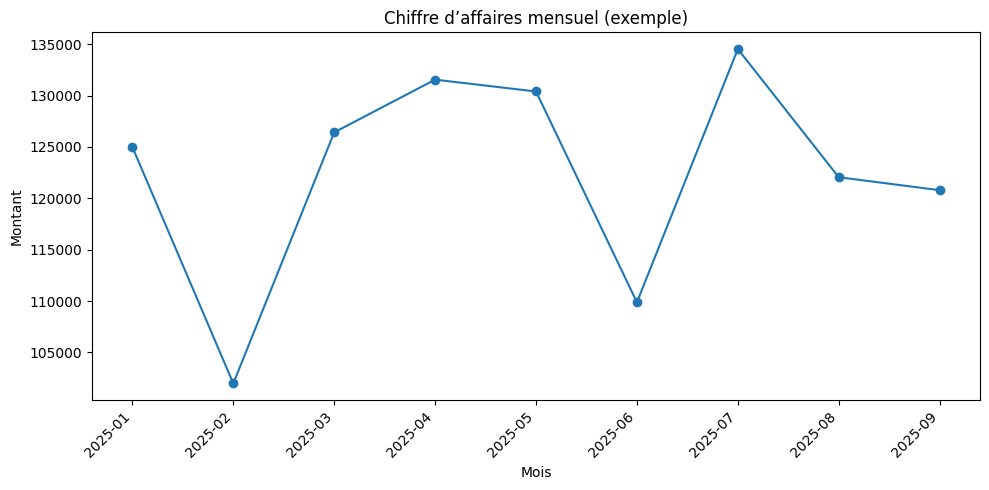

In [46]:
import matplotlib.pyplot as plt
from itertools import islice
from pathlib import Path

output_dir = out_dir / "output"
output_dir.mkdir(parents=True, exist_ok=True)

x = range(len(sales_by_month))
labels = [f"{int(y)}-{int(m):02d}" for y, m in zip(sales_by_month["year"], sales_by_month["month"])]

plt.figure(figsize=(10, 5))
plt.plot(x, sales_by_month["amount"], marker="o")
plt.title("Chiffre d’affaires mensuel (exemple)")
plt.xlabel("Mois")
plt.ylabel("Montant")

step = max(1, len(x) // 10)
plt.xticks(
    ticks=list(islice(x, 0, len(x), step)),
    labels=list(islice(labels, 0, len(labels), step)),
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.savefig(output_dir / "monthly_sales.png")
plt.show()



### TP : exercices proposés

##### 1. Ajouter une dimension Promotion et lier au fait.

In [47]:
promotion_names = [f"Promotion {i}" for i in range(1, 6)]

dim_promotion = pd.DataFrame({
    "promotion_sk": range(len(promotion_names)),
    "promotion_name": promotion_names,
    "discount_rate": [0.0, 0.10, 0.15, 0.20, 0.25]
})

print("dim_promotion")
print(dim_promotion)



dim_promotion
   promotion_sk promotion_name  discount_rate
0             0    Promotion 1           0.00
1             1    Promotion 2           0.10
2             2    Promotion 3           0.15
3             3    Promotion 4           0.20
4             4    Promotion 5           0.25


In [48]:
dim_promotion_path = dim_dir / "dim_promotion.csv"
dim_promotion.to_csv(dim_promotion_path, index=False)
print("dim_promotion.csv sauvegardé :", dim_promotion_path)

dim_promotion.csv sauvegardé : c:\Users\24160\Desktop\TP\data\dim\dim_promotion.csv


In [49]:
fact_sales["promotion_sk"] = rng.choice(dim_promotion["promotion_sk"], size=len(fact_sales))

print("fact_sales avec promotion_sk:")
print(fact_sales[["order_line_id", "product_sk", "promotion_sk"]].head())


fact_sales avec promotion_sk:
      order_line_id  product_sk  promotion_sk
1835           1836           8             1
1961           1962          38             1
1007           1008           7             3
1778           1779          54             3
928             929          20             1


In [50]:
fact_sales_with_promo = fact_sales.merge(dim_promotion, on="promotion_sk")

print("Aperçu de la jointure fact_sales + dim_promotion :")
print(fact_sales_with_promo[["order_line_id", "product_sk", "promotion_name", "discount_rate"]].head())

fact_sales_with_promo_path = fact_dir / "fact_sales_with_promotion.csv"
fact_sales_with_promo.to_csv(fact_sales_with_promo_path, index=False)

if fact_sales_with_promo_path.exists():
    print("Fichier sauvegardé :", fact_sales_with_promo_path.resolve())
else:
    print("Erreur : fichier non sauvegardé.")



Aperçu de la jointure fact_sales + dim_promotion :
   order_line_id  product_sk promotion_name  discount_rate
0           1836           8    Promotion 2            0.1
1           1962          38    Promotion 2            0.1
2           1008           7    Promotion 4            0.2
3           1779          54    Promotion 4            0.2
4            929          20    Promotion 2            0.1
Fichier sauvegardé : C:\Users\24160\Desktop\TP\data\fact\fact_sales_with_promotion.csv


##### 2. Créer une table fact_inventory (stock journalier) et comparer CA vs stock.

In [51]:
product_ids = dim_product["product_sk"].unique()
dates = dim_date["date"].unique()

inventory_data = []

for date in dates:
    for product_id in product_ids:
        stock = rng.integers(20, 100)  
        inventory_data.append({
            "date": date,
            "product_sk": product_id,
            "stock": stock
        })

fact_inventory = pd.DataFrame(inventory_data)

print("Aperçu de la table fact_inventory :")
print(fact_inventory.head())
print("Nombre de lignes :", len(fact_inventory))


Aperçu de la table fact_inventory :
        date  product_sk  stock
0 2025-01-01           1     63
1 2025-01-01           2     60
2 2025-01-01           3     82
3 2025-01-01           4     56
4 2025-01-01           5     67
Nombre de lignes : 16380


In [52]:
sales_by_product_date = fact_sales.groupby(["date_sk", "product_sk"], as_index=False)["amount"].sum()

comparison_df = (
    sales_by_product_date
    .merge(dim_date[["date_sk", "date"]], on="date_sk")
    .merge(fact_inventory, on=["date", "product_sk"], how="left")
)

print("\nAperçu comparaison CA vs Stock :")
print(comparison_df[["date", "product_sk", "amount", "stock"]].head(10))



Aperçu comparaison CA vs Stock :
        date  product_sk   amount  stock
0 2025-01-01           1   717.56     63
1 2025-01-01           2   595.38     60
2 2025-01-01          10   360.84     82
3 2025-01-01          13   357.02     20
4 2025-01-01          14   552.95     63
5 2025-01-01          24   879.00     41
6 2025-01-01          49   407.88     58
7 2025-01-02          15   906.85     54
8 2025-01-02          36  1639.60     87
9 2025-01-02          51   188.74     32


In [53]:
fact_inventory_path = fact_dir / "fact_inventory.csv"
fact_inventory.to_csv(fact_inventory_path, index=False)

print("\nfichier fact_inventory.csv sauvegardé :", fact_inventory_path)



fichier fact_inventory.csv sauvegardé : c:\Users\24160\Desktop\TP\data\fact\fact_inventory.csv


##### 3. Mettre en place une dimension SCD2 sur dim_customer (valid_from/to, is_current).

In [54]:
from datetime import datetime

now = pd.Timestamp("2025-01-01") 
max_date = pd.Timestamp("9999-12-31")

dim_customer_scd2 = dim_customer.assign(
    valid_from=now,
    valid_to=max_date,
    is_current=True
)

print("Table dim_customer SCD2 initialisée :")
print(dim_customer_scd2.head(3))


Table dim_customer SCD2 initialisée :
   customer_id    name              email country  customer_sk valid_from  \
0            1  Cust 1  user1@example.com      FR            1 2025-01-01   
1            2  Cust 2  user2@example.com      UK            2 2025-01-01   
2            3  Cust 3  user3@example.com      IT            3 2025-01-01   

    valid_to  is_current  
0 9999-12-31        True  
1 9999-12-31        True  
2 9999-12-31        True  


In [55]:
customers_to_update = rng.choice(dim_customer["customer_id"], 20, replace=False)

dim_customer_scd2.loc[
    dim_customer_scd2["customer_id"].isin(customers_to_update),
    ["valid_to", "is_current"]
] = [now, False]

updated_customers = dim_customer_scd2[
    dim_customer_scd2["customer_id"].isin(customers_to_update)
].copy()
updated_customers["country"] = "US"
updated_customers["valid_from"] = now + pd.Timedelta(days=1)
updated_customers["valid_to"] = max_date
updated_customers["is_current"] = True

dim_customer_scd2 = pd.concat([dim_customer_scd2, updated_customers], ignore_index=True)

print("Exemple de mise à jour SCD2 :")
print(dim_customer_scd2[dim_customer_scd2["customer_id"].isin(customers_to_update)].sort_values("customer_id"))


Exemple de mise à jour SCD2 :
     customer_id      name                email country  customer_sk  \
0              1    Cust 1    user1@example.com      FR            1   
120            1    Cust 1    user1@example.com      US            1   
121            9    Cust 9    user9@example.com      US            9   
8              9    Cust 9    user9@example.com      DE            9   
11            12   Cust 12   user12@example.com      US           12   
122           12   Cust 12   user12@example.com      US           12   
123           19   Cust 19   user19@example.com      US           19   
18            19   Cust 19   user19@example.com      US           19   
19            20   Cust 20   user20@example.com      ES           20   
124           20   Cust 20   user20@example.com      US           20   
125           23   Cust 23   user23@example.com      US           23   
22            23   Cust 23   user23@example.com      DE           23   
26            27   Cust 27   user2

In [56]:
dim_customer_scd2_path = dim_dir / "dim_customer_scd2.csv"
dim_customer_scd2.to_csv(dim_customer_scd2_path, index=False)

print("Fichier dim_customer_scd2.csv sauvegardé :", dim_customer_scd2_path)


Fichier dim_customer_scd2.csv sauvegardé : c:\Users\24160\Desktop\TP\data\dim\dim_customer_scd2.csv


##### 4. Construire une vue matérialisée des ventes hebdomadaires.

In [57]:
sales_with_week = fact_sales.merge(dim_date[["date_sk", "year", "week"]], on="date_sk")


In [58]:
weekly_sales = (
    sales_with_week
    .groupby(["year", "week"], as_index=False)["amount"]
    .sum()
    .sort_values(["year", "week"])
)


In [59]:
print("Aperçu des ventes hebdomadaires :")
print(weekly_sales.head())


Aperçu des ventes hebdomadaires :
   year  week    amount
0  2025     1  19420.91
1  2025     2  25056.32
2  2025     3  31635.13
3  2025     4  28536.92
4  2025     5  23722.91


In [60]:
weekly_sales_path = fact_dir / "weekly_sales.csv"
weekly_sales.to_csv(weekly_sales_path, index=False)

print("weekly_sales.csv sauvegardé :", weekly_sales_path)

weekly_sales.csv sauvegardé : c:\Users\24160\Desktop\TP\data\fact\weekly_sales.csv


##### 5. Ajouter des règles DQ (emails valides, valeurs non nulles) et un rapport d’anomalies

In [61]:
import re

def is_valid_email(email):
    return bool(re.match(r"^[^@]+@[^@]+\.[^@]+$", str(email)))

dq_report = dim_customer.copy()

dq_report["email_valid"] = dq_report["email"].apply(is_valid_email)
dq_report["name_not_null"] = dq_report["name"].notnull()
dq_report["email_not_null"] = dq_report["email"].notnull()
dq_report["country_not_null"] = dq_report["country"].notnull()


In [62]:
dq_report["is_anomaly"] = ~(
    dq_report["email_valid"] &
    dq_report["name_not_null"] &
    dq_report["email_not_null"] &
    dq_report["country_not_null"]
)


In [63]:
print("Aperçu des anomalies DQ détectées :")
print(dq_report[dq_report["is_anomaly"]].head())

dq_path = out_dir / "anomalies.csv"
dq_report[dq_report["is_anomaly"]].to_csv(dq_path, index=False)

if dq_path.exists():
    print("anomalies.csv sauvegardé :", dq_path.resolve())
else:
    print("Erreur : anomalies.csv non sauvegardé.")


Aperçu des anomalies DQ détectées :
Empty DataFrame
Columns: [customer_id, name, email, country, customer_sk, email_valid, name_not_null, email_not_null, country_not_null, is_anomaly]
Index: []
anomalies.csv sauvegardé : C:\Users\24160\Desktop\TP\data\anomalies.csv


### Exemple flocon : dimension Géographie

In [75]:
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent
dim_dir = project_root / "data" / "dim"
dim_dir.mkdir(parents=True, exist_ok=True)

dim_pays = pd.DataFrame({
    "id_pays": [1, 2],
    "pays": ["France", "Allemagne"],
    "code_iso2": ["FR", "DE"]
})
dim_pays.to_csv(dim_dir / "dim_pays.csv", index=False)

dim_region = pd.DataFrame({
    "id_region": [10, 20],
    "region": ["Île-de-France", "Bavière"],
    "id_pays": [1, 2]
})
dim_region.to_csv(dim_dir / "dim_region.csv", index=False)

dim_ville = pd.DataFrame({
    "id_ville": [100, 200],
    "ville": ["Paris", "Munich"],
    "id_region": [10, 20]
})
dim_ville.to_csv(dim_dir / "dim_ville.csv", index=False)

dim_magasin = pd.DataFrame({
    "sk_magasin": [1, 2, 3],
    "id_ville": [100, 100, 200],
    "nom_magasin": ["Magasin République", "Magasin Bastille", "Magasin Hauptplatz"],
    "type_magasin": ["Supermarché", "Hypermarché", "Supérette"]
})
dim_magasin.to_csv(dim_dir / "dim_magasin.csv", index=False)

print("Fichiers géographiques sauvegardés dans :", dim_dir.resolve())



Fichiers géographiques sauvegardés dans : C:\Users\24160\Desktop\TP\data\dim


In [76]:
import duckdb
from pathlib import Path

project_root = Path.cwd().parent
geo_db_path = project_root / "geo_dw.duckdb"
conn = duckdb.connect(geo_db_path)

print("Nouvelle base DuckDB géographique créée :", geo_db_path.resolve())


Nouvelle base DuckDB géographique créée : C:\Users\24160\Desktop\TP\geo_dw.duckdb


In [77]:
pays_path = dim_dir / "dim_pays.csv"
region_path = dim_dir / "dim_region.csv"
ville_path = dim_dir / "dim_ville.csv"
magasin_path = dim_dir / "dim_magasin.csv"

conn.execute(f"""
    CREATE TABLE dim_pays AS
    SELECT * FROM read_csv_auto('{pays_path.as_posix()}')
""")
conn.execute(f"""
    CREATE TABLE dim_region AS
    SELECT * FROM read_csv_auto('{region_path.as_posix()}')
""")
conn.execute(f"""
    CREATE TABLE dim_ville AS
    SELECT * FROM read_csv_auto('{ville_path.as_posix()}')
""")
conn.execute(f"""
    CREATE TABLE dim_magasin AS
    SELECT * FROM read_csv_auto('{magasin_path.as_posix()}')
""")

print("Toutes les tables géographiques ont été importées avec succès dans geo_dw.duckdb")

Toutes les tables géographiques ont été importées avec succès dans geo_dw.duckdb


In [79]:
df = conn.execute("""
    SELECT 
        m.sk_magasin,
        m.nom_magasin,
        m.type_magasin,
        v.ville,
        r.region,
        p.pays,
        p.code_iso2
    FROM dim_magasin m
    JOIN dim_ville v ON m.id_ville = v.id_ville
    JOIN dim_region r ON v.id_region = r.id_region
    JOIN dim_pays p ON r.id_pays = p.id_pays
""").fetchdf()

print("Jointure complète magasin → ville → région → pays :")
print(df)


Jointure complète magasin → ville → région → pays :
   sk_magasin         nom_magasin type_magasin   ville         region  \
0           1  Magasin République  Supermarché   Paris  Île-de-France   
1           2    Magasin Bastille  Hypermarché   Paris  Île-de-France   
2           3  Magasin Hauptplatz    Supérette  Munich        Bavière   

        pays code_iso2  
0     France        FR  
1     France        FR  
2  Allemagne        DE  


In [80]:
df.to_csv(dim_dir / "dim_magasin_flat.csv", index=False)
print("dim_magasin_flat.csv sauvegardé dans data/dim/")


dim_magasin_flat.csv sauvegardé dans data/dim/


In [82]:
flat_path = (dim_dir / "dim_magasin_flat.csv").as_posix()

conn.execute(f"""
    CREATE OR REPLACE TABLE dim_magasin_flat AS
    SELECT * FROM read_csv_auto('{flat_path}')
""")

print("Table dim_magasin_flat créée dans geo_dw.duckdb")



Table dim_magasin_flat créée dans geo_dw.duckdb
